# “数字信号处理”课程设计——工作台

本文件为课程设计项目“语音信号增采样”提供给一个设计、开发和测试的环境。

本文件属于课程设计的“源代码”部分，学生需要**连同课程设计报告一并提交**，并请注意以下要求：

* 保留完整的增采样方法的实现代码和输出结果，并进行适当的注释和说明。
* 删除所有多余的调试代码、无用输出结果等。
* 确保不需要任何改动（例如修改参数）就可以直接运行（即在JupyterLab中使用“Run All Cells”功能）。
* 本文件中可以包含原理说明、结果分析等非编程实现类的内容，但**只作为学生自己参考用**。教师将仅以课程设计报告中的相关内容作为评分依据。

In [168]:
import numpy as np
from scipy import signal
from scipy import fft
from scipy import interpolate
import matplotlib.pyplot as plt
import math
import warnings
# Import everything from `lib/dsp.py`.
from lib.dsp import *

warnings.filterwarnings("ignore")
# Un-comment the following line to use interactive matplotlib widget.
# %matplotlib widget

## 引言

以下的代码通过对一组特定信号的频谱分析，引导学生思考如何通过数字滤波的方法实现增采样。

定义一个信号发生函数，用于生成类似语音信号的信号序列。

In [169]:
def gen_signal(fs, n):
    """Generate a test signal that comsists of several sin components."""
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((0.30, 2*np.pi/fs * 1.0e3, 0))
    x_comp.append((0.25, 2*np.pi/fs * 1.5e3, 0))
    x_comp.append((0.20, 2*np.pi/fs * 2.0e3, 0))
    x_comp.append((0.15, 2*np.pi/fs * 2.5e3, 0))
    x_comp.append((0.10, 2*np.pi/fs * 3.0e3, 0))
    
    # Generate the sequence by combining all sin components.
    x = np.sum([seq_sin(A, w, phi, 0, n-1) for A, w, phi in x_comp], axis=0)[0]

    return x

画出三个信号及其频谱：
- 低采样率(8KHz)信号 `x`
- 对 `x` 进行样本间“插零”后的信号 `x_insert_0`
- 目标高采样率(8KHz*6=48KHz)信号 `x_target`

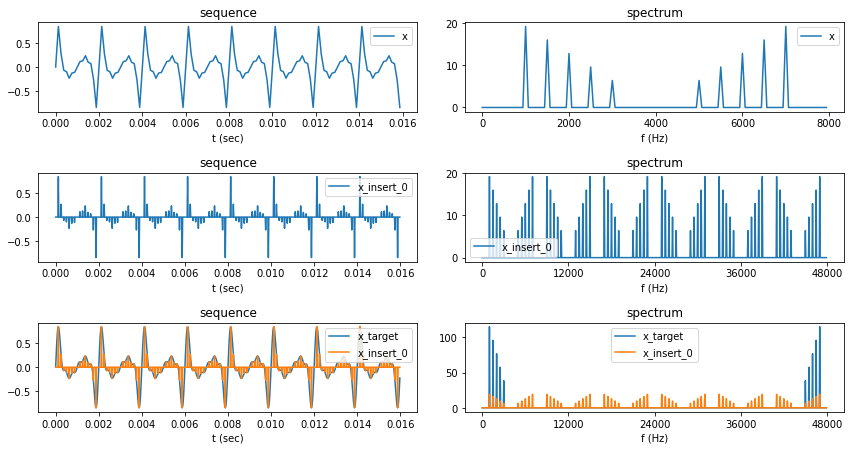

In [170]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8e3      # the low sampling rate
up_factor = 6   # upsampling factor

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

# Generate the low sampling rate signal.
x = gen_signal(fs_x, x_len)

# Insert zeros between samples.
x_insert_0 = np.zeros(x_len_up)
x_insert_0[::up_factor] = x

# Generate a high sampling rate target signal.
x_target = gen_signal(fs_up, x_len_up)

# Plot the signals for inspection.
fig, axs = plt.subplots(3, 2, figsize=(12,6))
fig.tight_layout(h_pad=4)
TITLES = ['sequence', 'spectrum']
plot_signals(['x'], [x], fs_x, axs[0,:], TITLES)
plot_signals(['x_insert_0'], [x_insert_0], fs_up, axs[1,:], TITLES)
plot_signals(
    ['x_target', 'x_insert_0'],
    [x_target, x_insert_0],
    fs_up, axs[2,:],
    TITLES
)

## 基于数字滤波的增采样方法设计

### 原理分析

- 数字滤波器的增采样方法的原理：主要通过插值运算来增加采样频率，如果我们需要将$x(n)$的抽样频率提高到$I$倍，则我们需要对$x(n)$进行插值。设序列$x(n)$的抽样频率为$f_s$，则抽样频率经$I$倍提升后的信号的抽样频率为$If_s$。 

- 一般我们采用零插值运算。 零插值运算的一般方法是在输入信号$x(n)$采样数据每相邻两点之间插入$I-1$个零。插入零值后，抽样频率就扩展了，也成为抽样率扩展器或上抽样器。零插值器不影响原来的频谱结构，所以对于数字音频处理来说，通常选择插零算法。 

- 在信号理论中，对序列$x(n)$进行整数倍内插，相当于对原序列在时域进行扩展。序列在时域扩展，由于信号采样率提高了$I$倍，则输出信号频谱为原始序列频谱经$I$倍压缩后得到的频谱，不仅包含基带频谱，即$|\omega_I| \leq \frac{\pi}{I}$之内的有用频谱，在$|\omega_I| \leq \pi$之内在产生的基带信号的镜像，它们中心频率在$\pm \frac{2\pi}{I},\pm \frac{4\pi}{I}...$处。    

- 为了滤除上述镜像分量，从频域上看，要加一个冲激响应为$h(n)$的数字低通滤波器，以便消除这些不需要的镜像部分；从时域上看，则是平滑作用，对两个连贯的样值之间的$(I-1)$个零值点进行插值，得到插值后的输出值。$h(n)$要逼近的理想低通频率特性可表示为$H(e^{j\omega_I})=\begin{cases} L&|\omega_I|\leq\frac{\Omega_sT_I}{2}=\frac{\pi}{I}\\0 & n=其他 \\ \end{cases}$。为了得到插值后信号的正确幅值，滤波器增益应为上式中的$I$。实际上，由于滤波器滤除掉镜像分量后，在$0\leq\omega_I\leq\pi$的范围内只保留$I$个样本中的一个样本，而将$I-1$个镜像分量滤除掉了，使信号平均能量减少了$\frac{1}{I^2}$倍，因而内插滤波器的增益必须是$I$，以补偿这一能量的损失。  

- 在本实验中，将低采样率的信号`x`通过插零得到 `x_insert_0`， $$ x\_insert\_0=\begin{cases} x(\frac{n}{I}) & n=0,\pm I,\pm 2I,...\\ 0 & n=其他 \\ \end{cases}$$将 `x_insert_0`再输入到一个截止频率为$\omega=\frac{\pi}{I}$的低通滤波器后，得到接近目标高采样率信号 `x_target` 的信号 `x_filter`。

### 原理验证

根据以上的原理分析，编写程序实现该方法的核心代码，以验证方法的正确性。

#### 滤波器设计
- 根据上述原理概述，我们可以知道我们就是需要设计一个符合设定指标的低通滤波器。而设计滤波器有两种方式，一种是选用IIR设计滤波器，一种是选用FIR设计滤波器，而根据之前的学习我们可以知道，FIR相对于IIR滤波器有一显著的优点即是：其可以保证严格的线性相位，而又考虑到我们此次是对音频信号进行处理。因为音频信号中有不同频率的信号，如果不是线性相位系统，则不同频率的声音会产生不同的时延，那么我们听到的处理过后的音频信号则会与实际音频信号不一致，其便失真了。  

- FIR滤波器的指标按照经验设定为低通滤波器阻带截止频率$f_{st}$=3KHz, 通带截止频率为$f_c$=5KHz，阻带最小衰减为$A_s$=76dB，用凯泽窗口(Kaiser)设计一个与上述滤波器技术指标相同的低通FIR滤波器。

N = 115, R_p = 0.002740, A_s = 78.373827


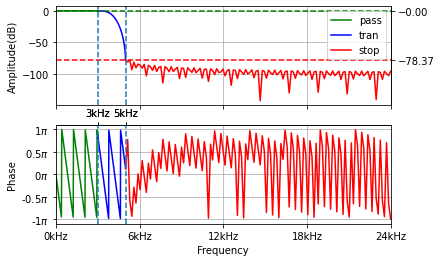

In [171]:
# All frequencies are in Hz.
f_st, f_p = 5e3, 3e3
A_s_target = 76    # in dB

# Find the minimum transition band width.
f_tran_min = abs(f_st-f_p)

# Compute parameter of kaiser window using signal.kaiserord. 
(N,beta)=signal.kaiserord(A_s_target, f_tran_min/(0.5*fs_up))      ##Width of transition region should be normalized
#N +=1

# Compute window property.
window = ('kaiser',beta)

# Compute the FIR coefficeints.
f_c = (f_p + f_st)/2
b = signal.firwin(N, f_c,window = window, fs=fs_up)
a = 1/up_factor      #由于滤波器滤除掉镜像分量后，只保留L个样本中的一个样本，使信号平均能量减少了，因而内插滤波器的增益必须是L，以补偿这一能量的损失。

# Analyze the filter.
bands= [
    ('pass', 0, f_p), 
    ('tran', f_p, f_st), 
    ('stop', f_st, fs_up/2)
    ]
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs_up, tick_format=tick_format_to_khz, amp_in_dB=True)
print('N = %d, R_p = %f, A_s = %f' % (N, R_p, A_s))

观察上图可知，设计的滤波器符合要求，可以实际使用。

#### 视觉评估
观察两个信号的时域序列、频谱的相似程度。将信号 `x_filter` 与 `x_target` 画在同一个坐标系中对齐以截取有效部分进行比较。

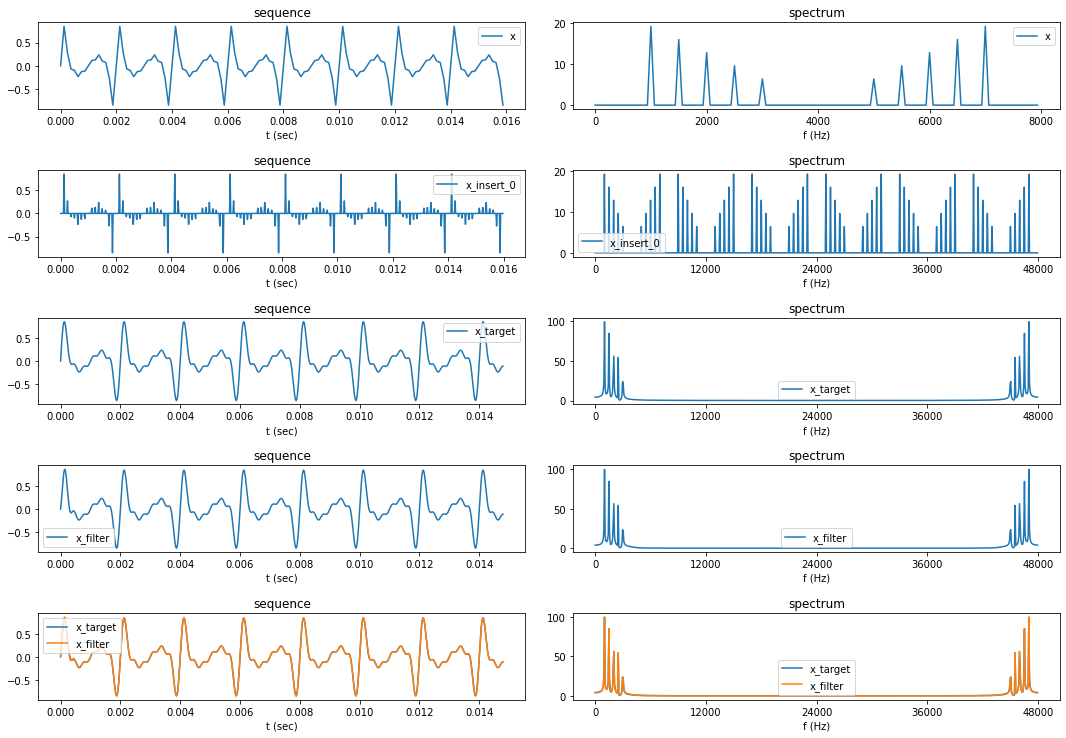

In [172]:
#Generate the output signal of FIR filter
x_filter = signal.lfilter(b=b, a=a, x=x_insert_0)

#Function to obtain delay
w, gd = signal.group_delay((b, a))
delay=int(gd[0])

# Plot the signals for inspection.
fig, axs = plt.subplots(5, 2, figsize=(15,10))
fig.tight_layout(h_pad=4) 
TITLES = ['sequence', 'spectrum']
plot_signals(['x'], [x], fs_x, axs[0,:], TITLES)
plot_signals(['x_insert_0'], [x_insert_0], fs_up, axs[1,:], TITLES)
plot_signals(['x_target'], [x_target[:x_filter.size-delay]], fs_up, axs[2,:], TITLES)
plot_signals(['x_filter'], [x_filter[delay:]], fs_up, axs[3,:], TITLES)
plot_signals(
    ['x_target', 'x_filter'],
    [x_target[:x_filter.size-delay], x_filter[delay:]],
    fs_up, axs[4,:],
    TITLES
)

#### 客观评估
计算两个信号 `x_filter` 与 `x_target` 之间的信噪比SNR。

In [173]:
#Generate the output signal of FIR filter
x_filter = signal.lfilter(b=b, a=a, x=x_insert_0)

#Function to obtain delay
w, gd = signal.group_delay((b, a))
delay = int(gd[0])

PS = 0
PN = 0
for i in range(0,len(x_target)-delay):
    PS += (np.abs(x_target[i]))**2
    PN += (np.abs(x_filter[i+delay]-x_target[i]))**2
SNR = 10*np.log10(PS/PN)
print("SNR=",SNR)

SNR= 30.125475977477926


#### 原型实现

完成以上原理验证后，将核心代码进行优化整合，实现可方便重复使用的原型函数。

#### 基于数字滤波的增采样方法原型函数
- 根据上述原理验证，我们选择设计FIR低通滤波器，需要设定如下参数：
    - 必须输入的参数：
        - x：输入的语音信号
        - fs:输入信号的采样频率
        - up_factor：增采样因子
    - 可以选择输入的参数：
        - f_p：通带截止频率，设置为低采样语音信号的最高频率，但是当f_p > 3400时，选择为3400，具体原因看实验报告
        - f_st：阻带截止频率，设置为低采样语音信号采样频率的一半
        - A_s_target：目标衰减，默认为76
        - window：窗口选择，默认为凯撒窗口

In [174]:
#Upsampling function based on digital filter
def upsample_filter(x, fs, up_factor, f_p = None, f_st=None, A_s_target=None, window=None):
    """
    Realization of signal up-sampling based on digital filter.
    Parameters
    ----------
    x : array
        Low sampling rate signal.
    fs : int,float
        Original low sampling frequency.
    up_factor : int
        Upsampling factor.
    f_p : int,float
        Filter cutoff frequency,default is empty,f_st is in Hz.
    f_st : int,float
        Filter cutoff frequency,default is empty,f_st is in Hz.
    A_s_target : int,float
        Stop band target attenuation,default is None,f_st is in db.
    window :
        Filter usage window,default is empty.
    Returns
    -------
    x_filter : ndarray
        Upsampled signal realized after filtering.
    b , a : float
        Filter coefficient.
    Notes
    -----
    Window types:
    - 'boxcar','triang','blackman','hamming','hann'
    -  If it is not for these windows, use signal.kaiserord() to calculate the filter coefficients.
    """
    x_len = len(x)                   #Original signal length
    x_len_up = x_len * up_factor     #Signal length after upsampling
    fs_up = fs * up_factor           #Sampling frequency after upsampling
    
    # Insert zeros between samples.
    x_insert_0 = np.zeros(x_len_up)
    x_insert_0[::up_factor] = x 

    #When fst is not set,set fst.
    if f_st == None:
        X = np.fft.fft(x)
        for i in range (int(len(x)/2),int(len(x))):
            if np.abs(X[i])>0.001:
                f_st=i/128*fs
                break
    if f_p == None:
        f_p = fs - f_st                  #The passband cut-off frequency is the sampling frequency minus the stopband cut-off frequency
    if A_s_target == None:
        A_s_target = round(-20*math.log(0.001/up_factor,10)) 
    print('A_s_target = ', A_s_target)
    
    #When f_p > 3400,set f_p,f_st
    if f_p > 3400:
        f_p = 3400
        f_st = fs - f_p
    f_tran = f_st - f_p                 #set the transition zone
    
    f_c = (f_p + f_st)/2                #Cut off frequency of filter
    windows = ['boxcar','triang','blackman','hamming','hann'] # windows
    a = 1/up_factor                     #Gain I 
    
    # Compute the order 
    for i in windows:
        # choose the window
        if window==windows:
            if window=='boxcar':
                window_tran=1.8*(fs_up/2)  
            if window=='triang':
                window_tran=6.1*(fs_up/2)
            if window=='blackman': 
                window_tran=11*(fs_up/2)
            if window=='hamming':
                window_tran=6.6*(fs_up/2)
            if window=='hann':
                window_tran=6.2*(fs_up/2)
            N=int(np.ceil(window_tran/f_tran))
            b = signal.firwin(N, f_c,window = window, fs=fs_up)       
        else:
            (N,beta)=signal.kaiserord(A_s_target, f_tran/(0.5*fs_up)) 
            window = ('kaiser',beta)
            b = signal.firwin(N, f_c,window = window, fs=fs_up)
    
    #analyze_filter
    bands= [
        ('pass', 0, f_p), 
        ('tran', f_p, f_st), 
        ('stop', f_st, fs_up/2)
            ]
    R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=False, fs=fs_up, tick_format=tick_format_to_khz, amp_in_dB=True)
    while(A_s<A_s_target):
        N = N+1
        b = signal.firwin(N, f_c,window = window, fs=fs_up)
        R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=False, fs=fs_up, tick_format=tick_format_to_khz, amp_in_dB=True)
    
    #get x_filter
    x_filter = signal.lfilter(b=b, a=a, x=x_insert_0)
    return x_filter,b,a

#### 视觉评估原型函数

In [175]:
# Visual evaluation function
def evaluate_visual(x_1, x_2, b, a, fs):
    """
    Visual evaluation function.
    Parameters
    ----------
    x_1, x_2 : array
        Target signal and the generate signal.
    b, a : float
        Filter coefficient.
    fs : int
        Sampling frequency after upsampling.
    Returns
    -------
    x_1, x_2 : array
        Target signal and the generate signal.
    spectrum_1,spectrum_2 : array
        Spectrum of x_1 and x_2. 
    """
    #Function to obtain delay
    if len(b)==1:
        delay=0
    w, gd = signal.group_delay((b, a))
    delay = int(gd[0])
    
    # Determine objective function and filter function
    n_0_x1=0
    n_0_x2=0
    for i in range(len(x_1)):
        if x_1[i]!=0:
            break
        else:
            n_0_x1=n_0_x1+1
    for i in range(len(x_2)):
        if x_2[i]!=0:
            break
        else:
            n_0_x2=n_0_x2+1
    if n_0_x1>n_0_x2:
        x_filter = x_1
        x_target = x_2
    else:
        x_filter = x_2
        x_target = x_1
    
    # Plot the signals for inspection.
    fig, axs = plt.subplots(3, 2, figsize=(15,10))
    fig.tight_layout(h_pad=4) 
    TITLES = ['sequence', 'spectrum']
    plot_signals(['x_1(x_target)'], [x_target[:len(x_target)-delay]], fs, axs[0,:], TITLES)
    plot_signals(['x_2(x_filter)'], [x_filter[delay:]], fs, axs[1,:], TITLES)
    plot_signals(
        ['x_1(x_target)', 'x_2(x_filter)'],
        [x_target[:len(x_1)-delay], x_filter[delay:]],
        fs, axs[2,:],
        TITLES
    )
    spectrum_1=abs(fft.fft(x_target[:len(x_1)-delay]))
    spectrum_2=abs(fft.fft(x_filter[delay:]))
    return x_1,x_2,spectrum_1,spectrum_2

#### 客观评估原型函数

In [176]:
#Objective evaluation function
def evaluate_objective(x_1, x_2, b, a):
    """
    Objective evaluation function.
    Parameters
    ----------
    x_1, x_2 : array
        Target signal and the generate signal.
    b, a : float
        Filter coefficient.
    fs : int
        Sampling frequency after upsampling.
    Returns
    -------
    SNR : float
        SNR between two signals.
    """
    #Function to obtain delay
    if len(b)==1:
        delay=0
    else:
        w,gd=signal.group_delay((b,a))
        delay=int(gd[0])
    
    # Determine objective function and filter function
    n_0_x1 = 0
    n_0_x2 = 0
    for i in range(len(x_1)):
        if x_1[i] != 0:
            break
        else:
            n_0_x1 = n_0_x1+1
    for i in range(len(x_2)):
        if x_2[i] != 0:
            break
        else:
            n_0_x2 = n_0_x2+1
    if n_0_x1 > n_0_x2:
        x_filter = x_1
        x_target = x_2
    else:
        x_filter = x_2
        x_target = x_1
    
    # calculate SNR
    PS = 0
    PN = 0
    for i in range(0,len(x_target)-delay):
        PS += (np.abs(x_target[i]))**2
        PN += (np.abs(x_filter[i+delay]-x_target[i]))**2
    SNR = 10*np.log10(PS/PN)
    return SNR

#### 单元测试函数

A_s_target =  76
SNR =  30.125475977477926
A_s_target =  76
SNR =  20.44179192236639
A_s_target =  76
SNR =  12.947192041010783


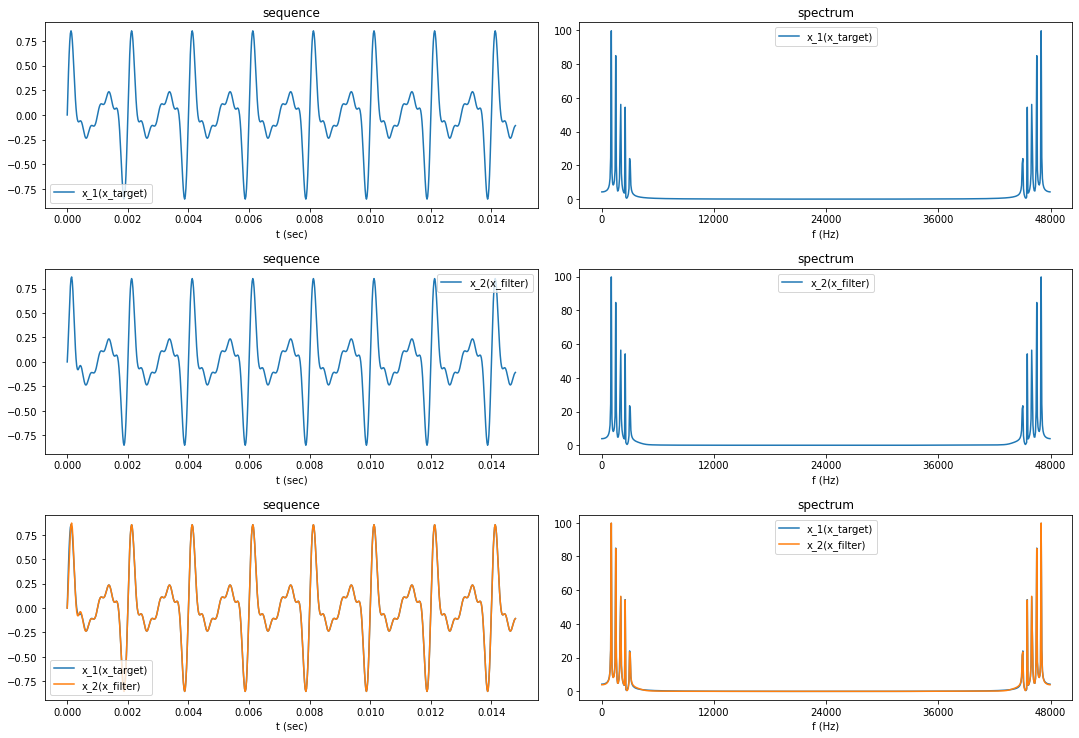

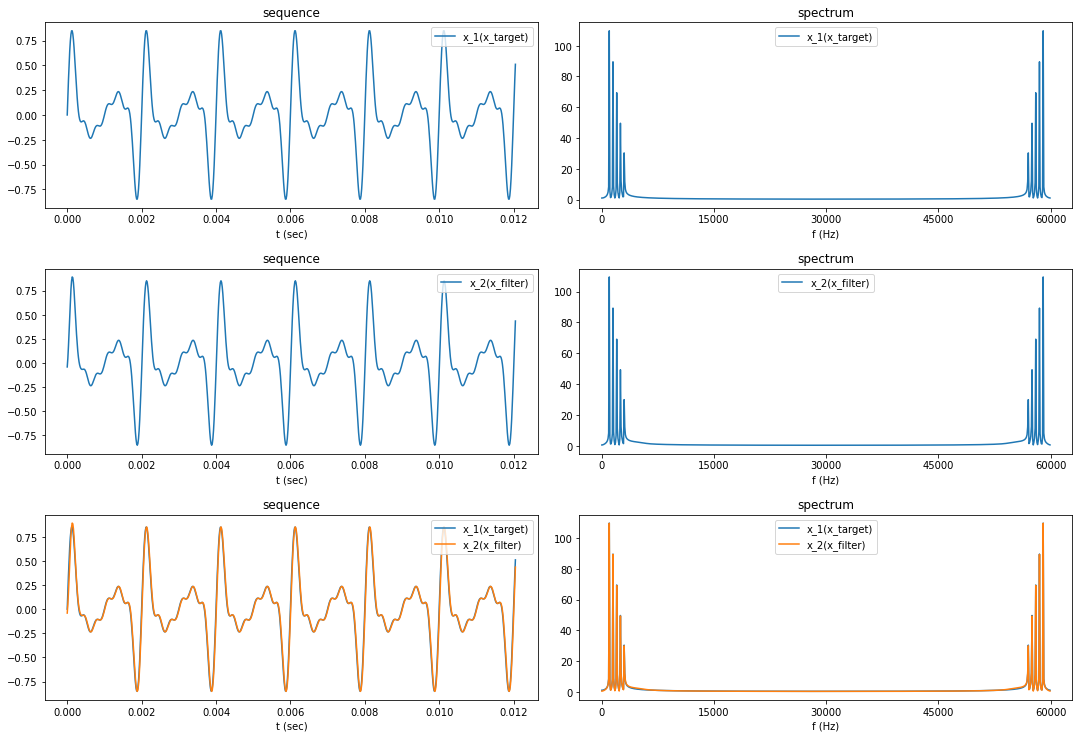

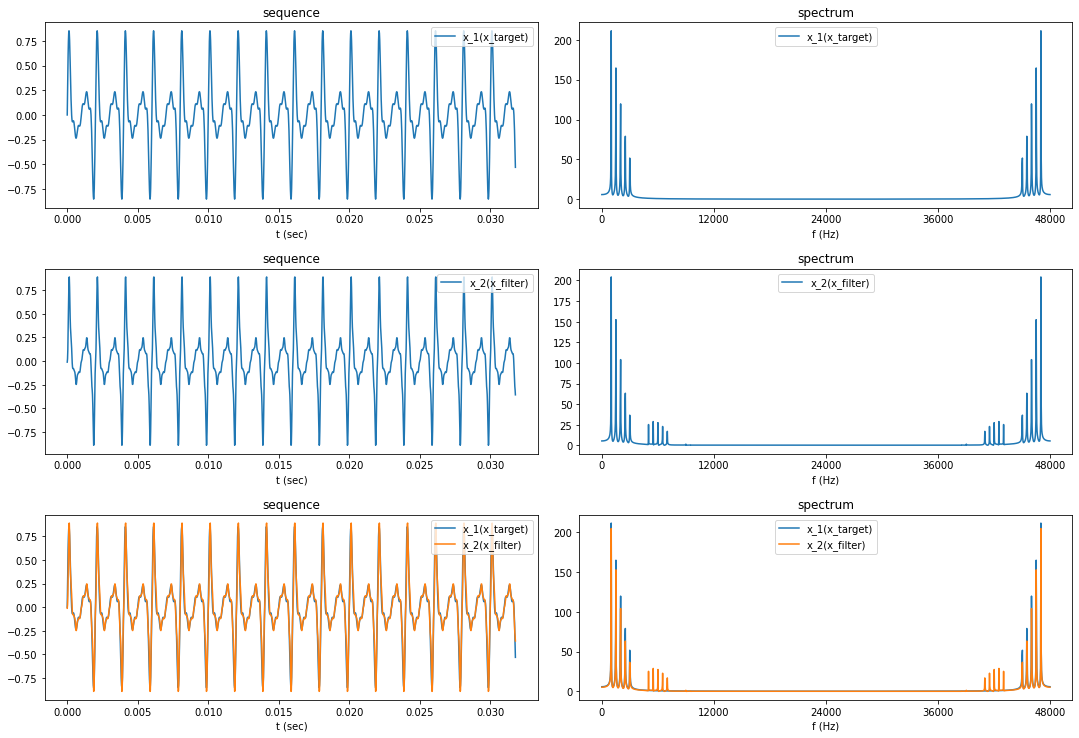

In [183]:
def test():
    #test_1
    x_len = 128     # length of the low sampling rate signal
    fs_x = 8e3      # the low sampling rate
    up_factor = 6   # upsampling factor

    fs_up = fs_x * up_factor
    x_len_up = x_len * up_factor

    # Generate the low sampling rate signal.
    x = gen_signal(fs_x, x_len)
    x_filter,b,a = upsample_filter(x, fs_x, up_factor)

    # Generate a high sampling rate target signal.
    x_target = gen_signal(fs_up, x_len_up)

    evaluate_visual(x_filter, x_target, b, a,fs_up)
    SNR = evaluate_objective(x_filter, x_target, b, a)
    print("SNR = ",SNR)
    
    #test_2 change fs_x
    x_len = 128     # length of the low sampling rate signal
    fs_x = 10e3      # the low sampling rate
    up_factor = 6   # upsampling factor

    fs_up = fs_x * up_factor
    x_len_up = x_len * up_factor

    # Generate the low sampling rate signal.
    x = gen_signal(fs_x, x_len)
    x_filter,b,a = upsample_filter(x, fs_x, up_factor)

    # Generate a high sampling rate target signal.
    x_target = gen_signal(fs_up, x_len_up)

    evaluate_visual(x_filter, x_target, b, a,fs_up)
    SNR = evaluate_objective(x_filter, x_target, b, a)

    print("SNR = ",SNR)
    
    #test_2 change x_len
    x_len = 256     # length of the low sampling rate signal
    fs_x = 8e3      # the low sampling rate
    up_factor = 6   # upsampling factor

    fs_up = fs_x * up_factor
    x_len_up = x_len * up_factor

    # Generate the low sampling rate signal.
    x = gen_signal(fs_x, x_len)
    x_filter,b,a = upsample_filter(x, fs_x, up_factor)

    # Generate a high sampling rate target signal.
    x_target = gen_signal(fs_up, x_len_up)

    evaluate_visual(x_filter, x_target, b, a,fs_up)
    SNR = evaluate_objective(x_filter, x_target, b, a)

    print("SNR = ",SNR)
    
test()

## 基于时域插值的增采样方法

### 原理分析

- 邻域插值(nearest neighbour interpolation)：通常有两组点坐标，第二组坐标就是在第一组坐标间插入的数据，其中第二组坐标里x_new的已知，邻域插值算法在选择每个对应x_new的y_new时，用第一组坐标里的每个y作为y_new,计算两个坐标间的距离d,取最小时的最为这个的值。实际算法：将插入各点的值设为x轴上最近的点的值。

- 线性插值(linear interpolation)：就是在两点间插入指定个数的数据点，使得这两点间的数（包括原来的点与插入的点）满足线性关系。实际算法：对相邻两点横纵坐标分别求N+1平均（N为需要插入的点数）
 

   
### 原理验证

* 查找可实现以上插值方法的函数库，并学习相关函数的使用方法，最终找到函数为interpolate.interp1d()。
* 编写简单代码，验证利用相关插值函数对低采样率信号 `x` 进行增采样的可行性。

定义一个信号发生函数，用于生成类似语音信号的信号序列。

In [178]:
#定义一个信号发生函数，用于生成类似语音信号的信号序列
def get_signal(fs, n, a):
    """Generate a test signal that comsists of several sin components.
    fs : int float
    Signal frequency.
    a : array
    Array of length can be set
    n : int
    Length of the sequence.
    """
     
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((0.30, 2*np.pi/fs * 1.0e3, 0))
    x_comp.append((0.25, 2*np.pi/fs * 1.5e3, 0))
    x_comp.append((0.20, 2*np.pi/fs * 2.0e3, 0))
    x_comp.append((0.15, 2*np.pi/fs * 2.5e3, 0))
    x_comp.append((0.10, 2*np.pi/fs * 3.0e3, 0))
    seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in a]), 0-n_min)
    # Generate the sequence by combining all sin components.
    x = np.sum([seq_sin(A, w, phi, 0, n-1) for A, w, phi in x_comp], axis=0)[0]

    return x

画出三个信号及其频谱：
- 生成低采样率(8KHz)信号 `y`，目标高采样率(8KHz*6=48KHz)信号 `y_target`
- 使用线性插值算法和最近邻域算法实现基于时域插值的增采样

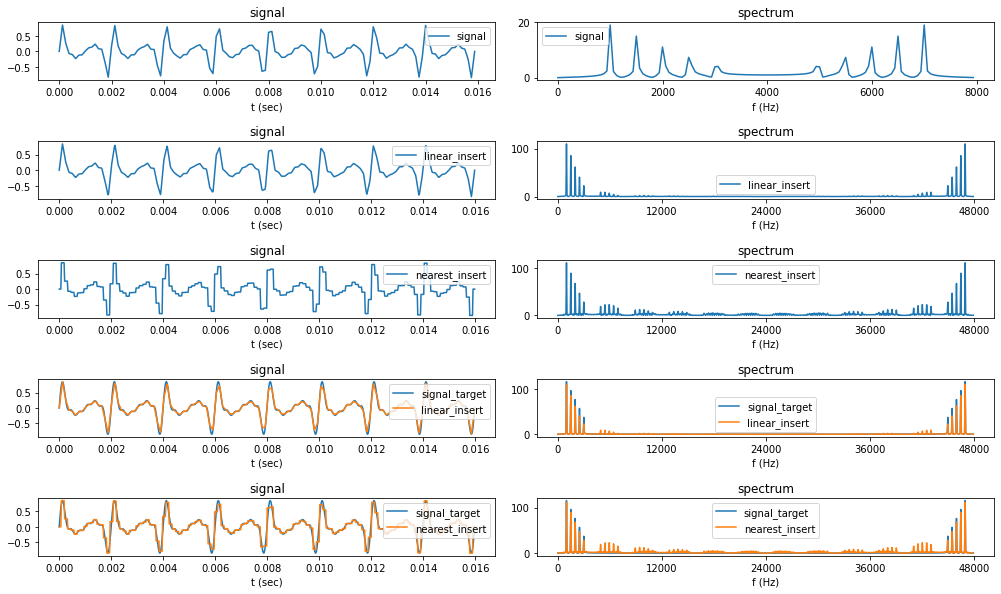

In [179]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8000    # the low sampling rate
up_factor = 6   # upsampling factor

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

#低采样率信号y
x=np.linspace(0,x_len,x_len)          #生成x数组
y = get_signal(fs_x, x_len, x)        #得到低采样率的信号y

#高采样率信号y
xnew=np.linspace(0,x_len,x_len_up)    #生成新的xnew数组：插入点数
y_target=get_signal(fs_x, x_len,xnew) #生成高采样率的目标信号y_target

#使用线性插值算法实现基于时域插值的增采样
kind_linear='linear'                  #线性插值算法
f_linear=interpolate.interp1d(x,y,kind=kind_linear)#输入x,y得到基于线性插值的逼近函数
ynew_linear=f_linear(xnew)            #输入新的xnew，生成基于线性插值的高采样频率信号

#使用最近邻域算法实现基于时域插值的增采样
kind_nearest='nearest'                #最近邻域算法
f_nearest=interpolate.interp1d(x,y,kind=kind_nearest)#输入x,y得到基于最近邻域插值的逼近函数
ynew_nearest=f_nearest(xnew)          #输入新的xnew，生成基于最近邻域的高采样频率信号

# Plot the signals for inspection.
fig, axs = plt.subplots(5, 2, figsize=(14,8))
fig.tight_layout(h_pad=4)
TITLES = ['signal', 'spectrum']
plot_signals(['signal'], [y], fs_x, axs[0,:], TITLES)
plot_signals(['linear_insert'], [ynew_linear], fs_up, axs[1,:], TITLES)
plot_signals(['nearest_insert'], [ynew_nearest], fs_up, axs[2,:], TITLES)
plot_signals(
    ['signal_target', 'linear_insert'],
    [y_target, ynew_linear],
    fs_up, axs[3,:],
    TITLES
)
plot_signals(
    ['signal_target', 'nearest_insert'],
    [y_target, ynew_nearest],
    fs_up, axs[4,:],
    TITLES
)

结果分析：
      
- 通过对比signal_target和linear_insert、nearest_insert之间的差异，发现采用scipy库中的interpolate的函数可以实现：基于线性插值和最近邻域插值两个算法的插值处理后的信号，所以认为利用相关插值函数对低采样率信号x进行增采样可行。             
- 对比linear_insert、nearest_insert发现，基于最近邻域插值算法得到的增采样信号比基于线性插值算法得到的增采样信号产生更多的高频成分，所以在此情况下线性插值算法更优

### 原型实现

完成以上原理验证后，将核心代码进行优化整合，实现可方便重复使用的原型函数。

原理说明：先用原信号长度和采样率确定时域横坐标，然后调用插值函数interpld生成一定条件下的插值函数f，最后使用f来计算得出高采样频率信号。

#### 基于时域插值的增采样方法原型函数

In [180]:
#生成低采样率的信号x
def get_lowsp_signal(fs_x, x_len):
    """------------------------.
    fs_x: int float
          Original low sampling frequency.
    x_len:int
          Length of the sequence.
    """
    x0=np.linspace(0,x_len,x_len)
    x = get_signal(fs_x, x_len, x0)#得到低采样率的信号x
    return x
    
def upsample_interp(x,fs_x,x_len,up_factor,kind):
    """------------------------.
    x : array
    Low sampling rate signal.
    fs_x: int float
    Original low sampling frequency.
    x_len:int
    Length of the sequence.
    up_factor:int
    Unsampling factor.
    kind:'linear' or 'nearest'
    Selection of Time Domain Interpolation method.
    Returns
    -------
    x_interp: array
    Up-sampled signal generated by time-domain interpolation method.
    """
    fs_up = fs_x * up_factor
    x_len_up = x_len * up_factor
    x0 = np.linspace(0,x_len,x_len)          #生成新的xnew数组：插入点数
    
    xnew=np.linspace(0,x_len,x_len_up)
    
    f=interpolate.interp1d(x0,x,kind=kind)   #选择时域插值的方法
    
    x_interp=f(xnew)                         #输入新的xnew，生成时域插值的高采样频率信号
    return  x_interp

# 绘制增采样结果与目标结果的对比图
def plt_upsample_interp(x,fs_x,x_len,up_factor,kind):
    """------------------------.
    x : array
        Low sampling rate signal.
    fs_x: int float
          Original low sampling frequency.
    x_len:int
          Length of the sequence.
    up_factor:int
              Unsampling factor.
    kind:'linear' or 'nearest'
         Selection of Time Domain Interpolation method.
    """
    fs_up = fs_x * up_factor
    x_len_up = x_len * up_factor
    
    xnew=np.linspace(0,x_len,x_len_up)#生成新的xnew数组：插入点数
    
    x_target=get_signal(fs_x, x_len,xnew)#生成高采样率的目标信号y_target
    #print('y_target',y_target)
    x_interp = upsample_interp(get_lowsp_signal(8000, 128),fs_x,x_len,up_factor,kind)
    
    fig, axs = plt.subplots(3, 2, figsize=(14,8))
    fig.tight_layout(h_pad=4)
    TITLES = ['signal', 'spectrum']
    plot_signals(['signal'], [x], fs_x, axs[0,:], TITLES)
    plot_signals(['x_interp'], [x_interp], fs_up, axs[1,:], TITLES)

    plot_signals(
        ['signal_target', 'x_interp'],
        [x_target, x_interp],
        fs_up, axs[2,:],
        TITLES
)

#### 单元测试函数

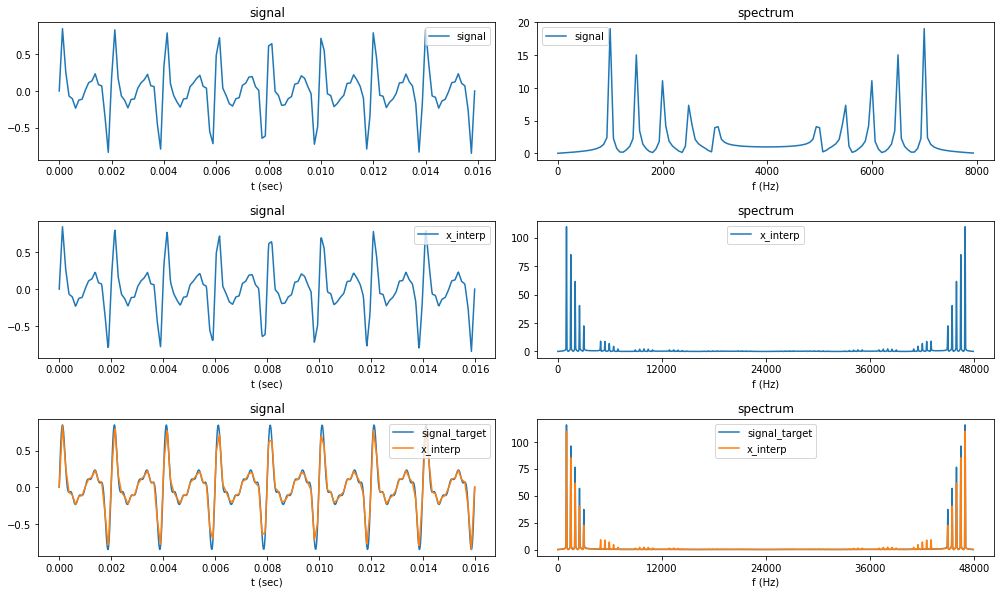

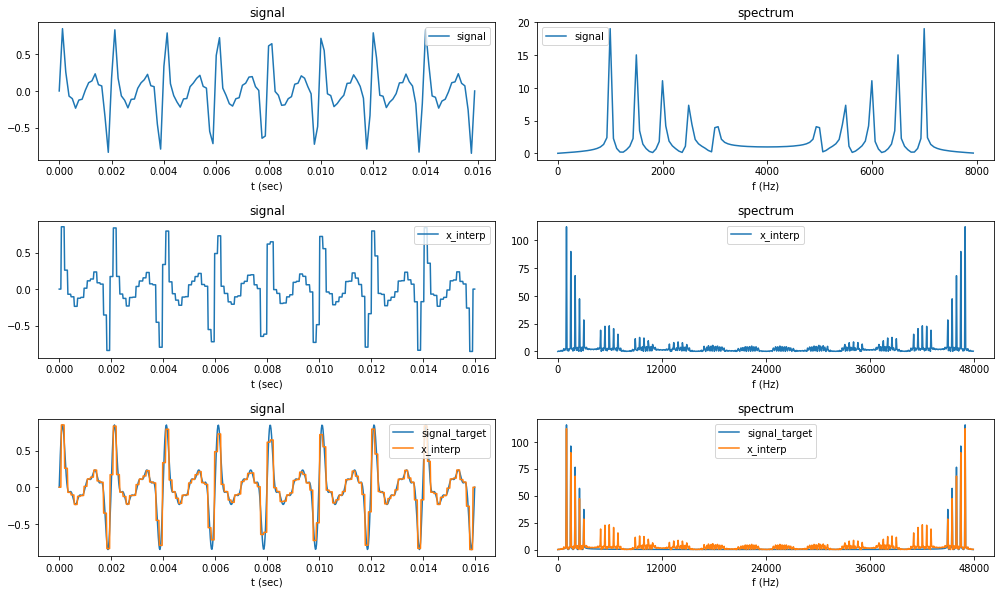

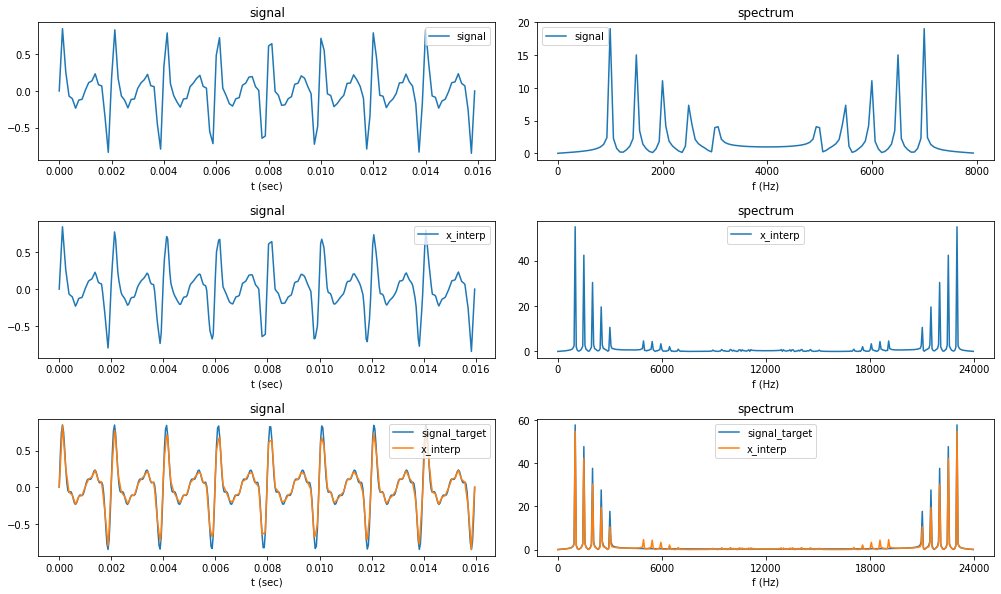

In [181]:
#单元测试
def test_upsample_interp():    
    #test1
    fs_x = 8000
    x_len = 128
    up_factor = 6
    kind = 'linear'
    x = get_lowsp_signal(8000, 128)                           #调用get_lowsp_signal得到低采样率信号
    x_interp = upsample_interp(x,fs_x,x_len,up_factor,kind)   #调用upsample_interp()函数得到增采样结果
    plt_upsample_interp(x,fs_x,x_len,up_factor,kind)          #调用plt_upsample_interp()函数绘制对比图象，后面两个单元测试同理
    
    #test2
    fs_x = 8000
    x_len = 128
    up_factor = 6
    kind = 'nearest'
    x = get_lowsp_signal(8000, 128)
    x_interp = upsample_interp(x,fs_x,x_len,up_factor,kind)
    plt_upsample_interp(x,fs_x,x_len,up_factor,kind)
    
    #test3
    fs_x = 8000
    x_len = 128
    up_factor = 3
    kind = 'linear'
    x = get_lowsp_signal(8000, 128)
    x_interp = upsample_interp(x,fs_x,x_len,up_factor,kind)
    plt_upsample_interp(x,fs_x,x_len,up_factor,kind)
test_upsample_interp()

#### 视觉评估以及客观评估

SNR(linear) =  14.701226679099122
SNR(nearest) =  8.498999125474562


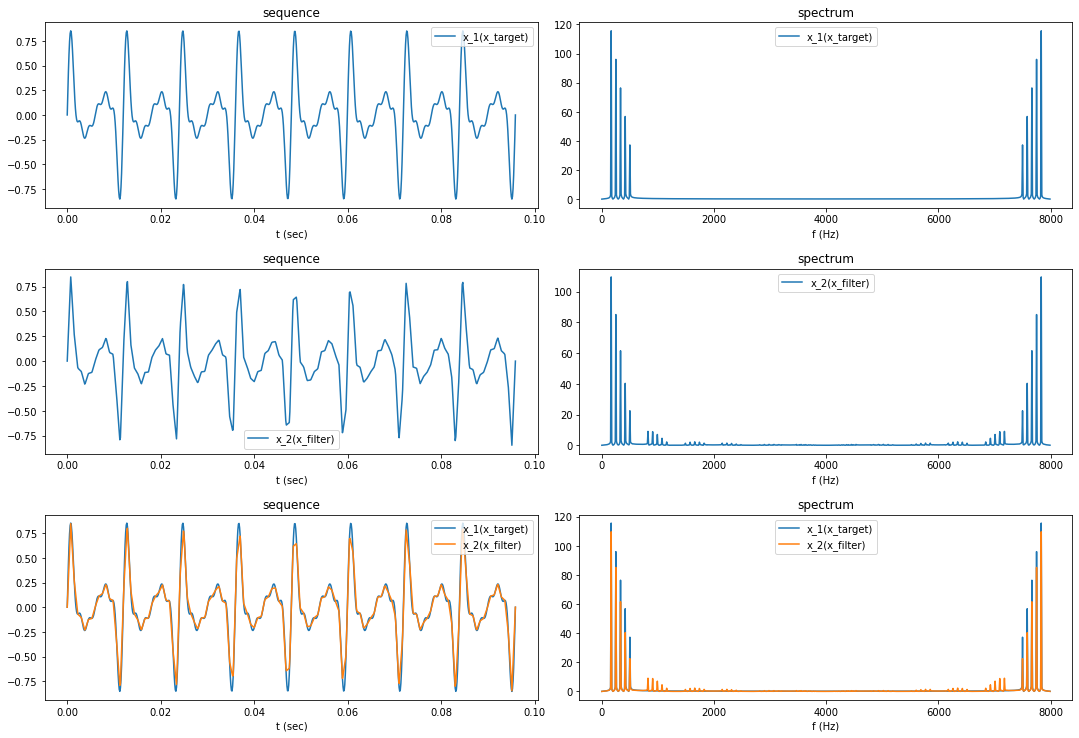

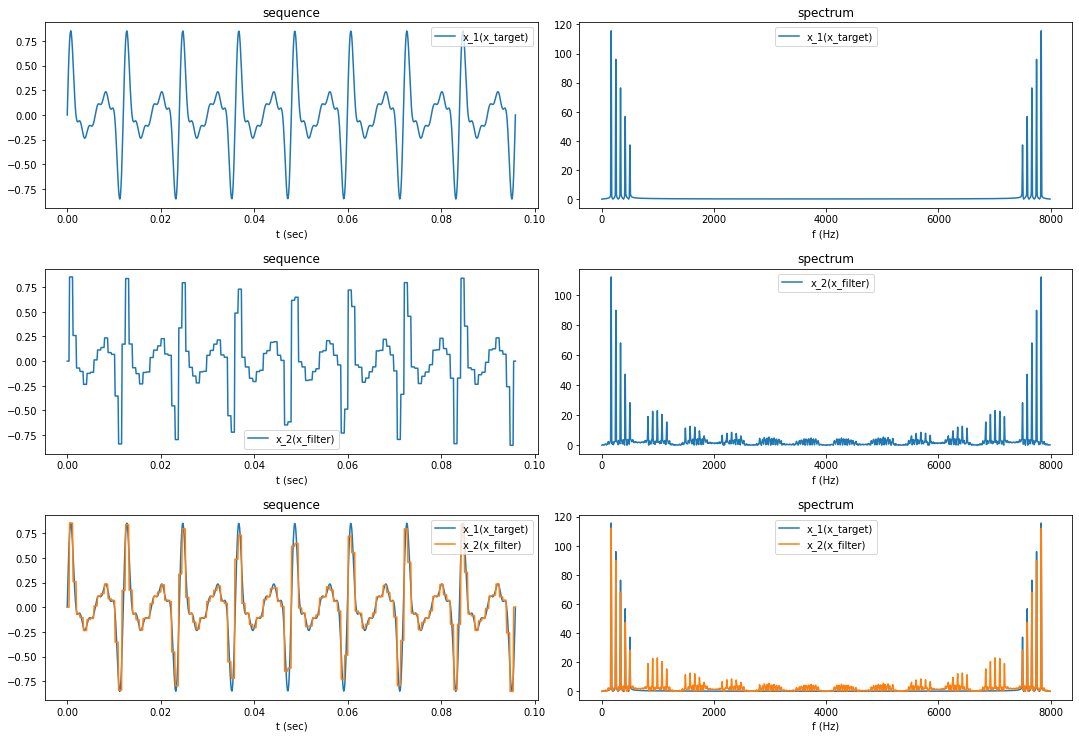

In [182]:
#测试是否能用视觉评估函数和客观评估函数 
def test_evaluate():    
    fs_x = 8000
    fs = 8000
    x_len = 128
    up_factor = 6
    kind = 'linear'
    a = [1]
    b = [1]
    x = get_lowsp_signal(8000, 128)
    x_1 = get_signal(fs_x, x_len,xnew)#调用get_lowsp_signal得到低采样率信号
    x_2 = upsample_interp(x,fs_x,x_len,up_factor,kind)
    evaluate_visual(x_1, x_2, b, a, fs)
    SNR = evaluate_objective(x_1, x_2, b, a)
    print('SNR(linear) = ',SNR)
    
    fs_x = 8000
    fs = 8000
    x_len = 128
    up_factor = 6
    kind = 'nearest'
    a = [1]
    b = [1]
    x = get_lowsp_signal(8000, 128)
    x_1 = get_signal(fs_x, x_len,xnew)#调用get_lowsp_signal得到低采样率信号
    x_2 = upsample_interp(x,fs_x,x_len,up_factor,kind)
    evaluate_visual(x_1, x_2, b, a, fs)
    SNR = evaluate_objective(x_1, x_2, b, a)
    print('SNR(nearest) = ',SNR)
test_evaluate()